# 频率域滤波

频率域滤波的理论部分转到`傅里叶变换相关公式的推导.md`

了解了一些数学背景之后，现在来学习后续的知识。在上面的公式推导中，我们涉及到的是一维的傅里叶变换，一张图像其实可以看做是一个二维的信号，所以应该应用二维的傅里叶变换。

傅里叶变换的函数在numpy里面有提供，具体的实现方式暂且不管，下面我们感性地认识一下信号、图像以及它们在频域的样子

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

下面是一维的傅里叶变换示意图（准确地说下面显示的是功率谱图像）

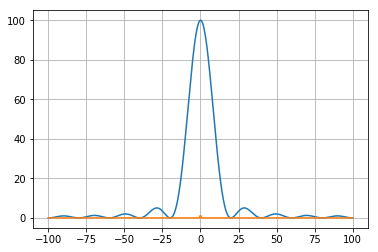

In [44]:
n = 2000
x = np.linspace(-100, 100, n)
y = np.zeros(n)
y[n // 2 - 5 : n // 2 + 5] = 1
# y = 1 / x * np.sin(x)
# plt.axis([-10, 10, -2, 2])
plt.plot(x, np.abs(np.fft.fftshift(np.fft.fft(y))) ** 2, x, y), plt.grid(True)
plt.show()

下面是二维数据的傅里叶频谱（功率谱）

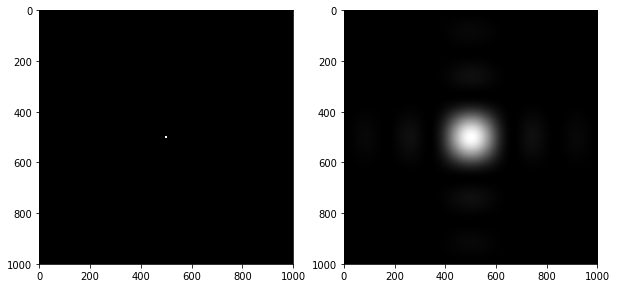

In [45]:
test = np.zeros((1000, 1000))
n = 3
center = 500
test[center - n : center + n, center - n : center + n] = 1.
ft = np.abs(np.fft.fftshift(np.fft.fft2(test))) ** 2
plt.figure(figsize = (10, 5))
plt.subplot(121), plt.imshow(test, cmap = 'gray')
plt.subplot(122), plt.imshow(ft, cmap = 'gray')
plt.show()

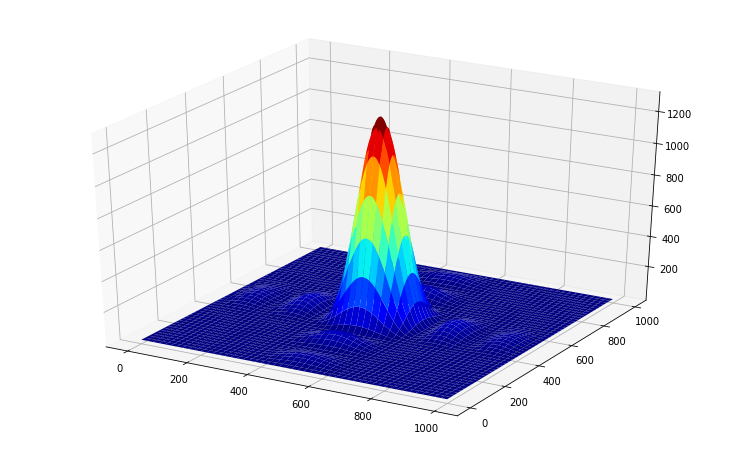

In [46]:
from mpl_toolkits.mplot3d import Axes3D
x, y = np.arange(1000), np.arange(1000)
xx, yy = np.meshgrid(x, y)
fig = plt.figure(figsize = (10, 6))
fig = Axes3D(fig)
fig.plot_surface(xx, yy, ft, cmap = 'jet')
plt.show()

下面用莱娜图得到她的傅里叶频谱

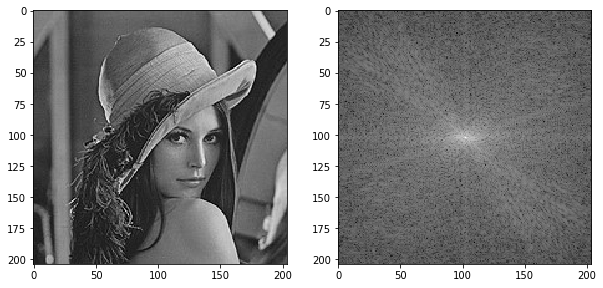

In [49]:
img = cv.imread('lena.jpg', 0)
plt.figure(figsize = (10, 5))
plt.subplot(121), plt.imshow(img, cmap = 'gray')
plt.subplot(122), plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(img)))**2), cmap = 'gray')
plt.show()

那么，逆傅里叶变换的结果是什么样的呢？

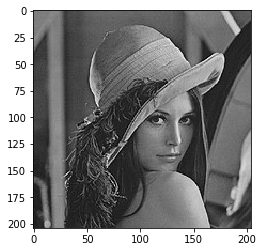

In [50]:
ft = np.fft.fft2(img)
reverse = np.fft.ifft2(ft).real
plt.imshow(reverse, cmap = 'gray')
plt.show()

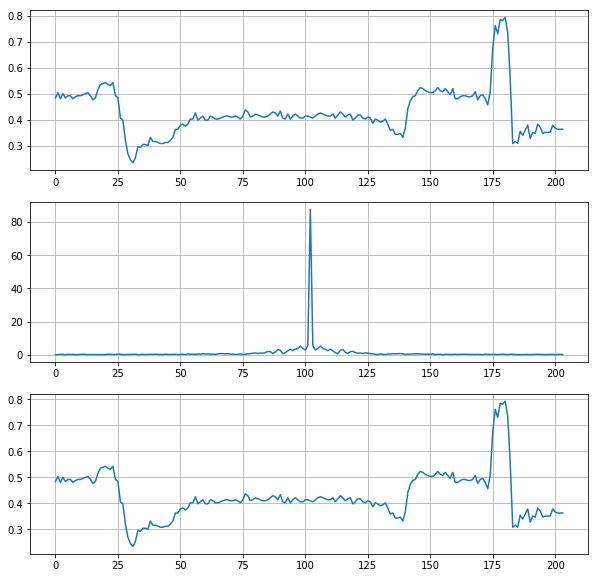

In [52]:
data = img[0, :] / 256
ft = np.fft.fft(data)
plt.figure(figsize = (10, 10))
plt.subplot(311), plt.plot(data), plt.grid(True)
plt.subplot(312), plt.plot(np.abs(np.fft.fftshift(ft))), plt.grid(True)
plt.subplot(313), plt.plot(np.fft.ifft(ft).real), plt.grid(True)
plt.show()

## 傅里叶变换的作用

傅里叶变换在信号处理中有着非常重要的作用，这是为什么？

在数学上，一个函数的傅里叶变换可以经过反变换得到原图像，而不会失去任何信息，而傅里叶变换的结果表现的是一个信号的频率组成情况，这就非常有意思了：频率的组成反映的是一个信号的整体情况，就像之前我们说到过的图像的灰度频率直方图，每一个在直方图中出现的灰度值可能散布在一张图像的任何角落，这样只要处理灰度直方图，就可以对整张图像的亮度和对比度进行调整。

同样，我们可以这样理解：组成一个信号的一种频率可能散布在一张图像的任何角落，那么，对频谱的一个小部分做归零处理或者做其他处理，就可以影响整张图像，这就是频率域上的滤波的概念来源。